In [ ]:
#default_exp audio.augment
#default_cls_lvl 3

# Data Augmentation for Audio

> Transforms to apply data augmentation to AudioSpectrograms and Signals

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.vision.core import *
from local.notebook.showdoc import show_doc
from local.audio.core import *

In [ ]:
# export
from torch import stack, zeros_like as t0, ones_like as t1
from torch.distributions.bernoulli import Bernoulli

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
x = AudioGetter("", recurse=True, folders=None)
files = x(p)
aud = AudioItem.create(files[0])

In [ ]:
sg_cfg = SpectrogramConfig(hop = 260)
cfg = AudioConfig(duration=1000, sg_cfg=sg_cfg)

In [ ]:
to_spectrogram = AudioToSpec(cfg)

In [ ]:
original_spec = to_spectrogram(aud)

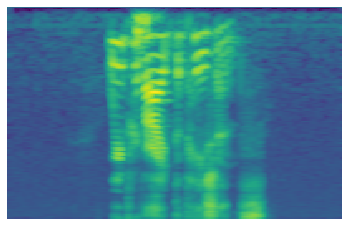

In [ ]:
original_spec.show()

<div class='alert alert-block alert-info'><strong>TO-DO:</strong> 
<li> Write tfm_pad_spectro for the case where the crop window is bigger than the original sg and it needs to be padded </li></ul>
</div>

In [ ]:
def CropTime(cfg):
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        '''Random crops full spectrogram to be length specified in ms by crop_duration'''
        sg = spectro.clone()
        w_crop = int((cfg._sr*cfg.duration)/(1000*cfg.sg_cfg.hop))
        w_sg   = sg.shape[-1]
        if   w_sg <  w_crop: return tfm_pad_spectro(sg)
        elif w_sg == w_crop: return sg
        else:
            crop_start = random.randint(0, int(w_sg - w_crop))
            sg_crop = sg[:,:,crop_start:crop_start+w_crop]
            sg_crop.sample_start = int(crop_start*cfg.sg_cfg.hop)
            sg_crop.sample_end   = sg_crop.sample_start + int(cfg.duration*cfg._sr)
            return sg_crop
    return _inner

In [ ]:
cfg.duration = 1000

if width of the spectrogram is less than width of the cropping window -> pad
if they are equal -> return unaltered
if width of spectro > width of cropping window, randomly select the cropping window

In [ ]:
cfg._sr = 16000

In [ ]:
crop_1000ms = CropTime(cfg)

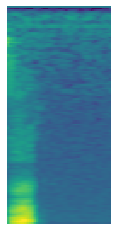

In [ ]:
crop_1000ms(original_spec).show()

<div class = "alert alert-block alert-info"> If we wanted to we could make a class for these transforms that keeps the masked portion as state so that we could write a decodes method to go back to the original</div>


In [ ]:
#export
def MaskFreq(num_masks=1, size=20, start=None, val=None, **kwargs):
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        '''Google SpecAugment time masking from https://arxiv.org/abs/1904.08779.'''
        start_ = start
        sg = spectro.clone()
        channel_mean = sg.contiguous().view(sg.size(0), -1).mean(-1)[:,None,None]
        mask_val = channel_mean if val is None else val
        c, y, x = sg.shape
        for _ in range(num_masks):
            mask = torch.ones(size, x) * mask_val    
            if start_ is None: start_= random.randint(0, y-size)
            if not 0 <= start_ <= y-size:
                raise ValueError(f"Start value '{start_}' out of range for AudioSpectrogram of shape {sg.shape}")
            sg[:,start_:start_+size,:] = mask
            start_ = None
        return sg
    return _inner

In [ ]:
#export
def MaskTime(num_masks=1, size=20, start=None, val=None, **kwargs):
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        sg = spectro.clone()
        sg = torch.einsum('...ij->...ji', sg)
        sg = MaskFreq(num_masks, size, start, val, **kwargs)(sg)
        return AudioSpectrogram(torch.einsum('...ij->...ji', sg))
    return _inner

In [ ]:
freq_mask = MaskSpec()

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 12.1 ms


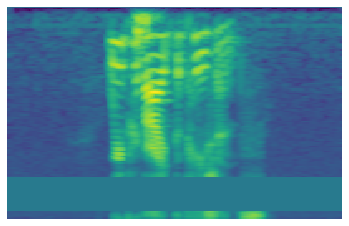

In [ ]:
%%time
freq_mask(original_spec).show()

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 12.3 ms


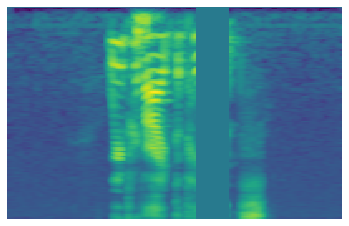

In [ ]:
%%time
time_mask = MaskSpec(mask_freq=False)
time_mask(original_spec).show()

## Pipeline testing

In [ ]:
files

(#3842) [/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00279.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00282.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00432.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00054.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0004_us_m0004_00110.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00180.wav...]

In [ ]:
oa = OpenAudio(files); oa

OpenAudio: True {'object': 'encodes'} {'object': 'decodes'}

In [ ]:
pipe = Pipeline([oa, AudioToSpec(AudioConfig()), MaskTime(), MaskFreq()], as_item=True)

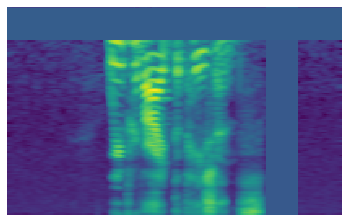

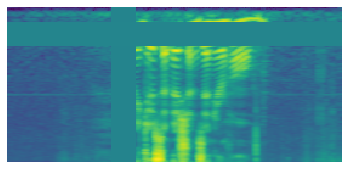

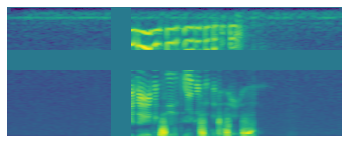

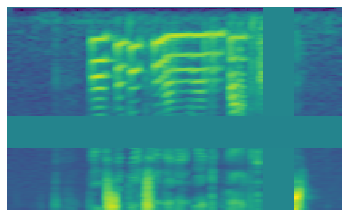

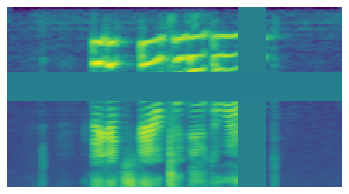

In [ ]:
for i in range(5): pipe.show(pipe(i))

## Preprocessing functions

In [ ]:
#export
def _merge_splits(splits, pad):
    clip_end = splits[-1][1]
    merged = []
    i=0
    while i < len(splits):
        start = splits[i][0]
        while splits[i][1] < clip_end and splits[i][1] + pad >= splits[i+1][0] - pad:
            i += 1
        end = splits[i][1]
        merged.append(np.array([max(start-pad, 0), min(end+pad, clip_end)]))
        i+=1
    return np.stack(merged)

def RemoveSilence(remove_type, threshold=20, pad_ms=200):
    def _inner(ai:AudioItem)->AudioItem:
        '''Split signal at points of silence greater than 2*pad_ms '''
        padding = int(pad_ms/1000*ai.sr)
        if(padding > ai.nsamples): return ai
        actual = ai.sig.clone()
        splits = split(actual.numpy(), top_db=threshold, hop_length=padding)
        if remove_type == "split":
            sig =  [actual[:,(max(a-padding,0)):(min(b+padding,ai.nsamples))] for (a, b) in _merge_splits(splits, padding)]
        elif remove_type == "trim":
            sig = [actual[:,(max(splits[0, 0]-padding,0)):splits[-1, -1]+padding]]
        elif remove_type == "all":
            sig = [torch.cat([actual[:,(max(a-padding,0)):(min(b+padding,ai.nsamples))] for (a, b) in _merge_splits(splits, padding)], dim=1)]
        else: 
            raise ValueError(f"Valid options for silence removal are None, 'split', 'trim', 'all' not {remove_type}.")
        return AudioItem((*sig, ai.sr))
    return _inner

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_dataloader.ipynb.
Converted 01a_script.ipynb.
Converted 02_data_transforms.ipynb.
Converted 03_data_pipeline.ipynb.
Converted 04_data_external.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_source.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 11_layers.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 15_callback_hook.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_metrics.ipynb.
Converted 21_tutorial_imagenette.ipynb.
Converted 30_text_core.ipynb.
Converted 31_text_data.ipynb.
Converted 32_text_models_awdlstm.ipynb.
Converted 33_test_models_core.ipynb.
Converted 34_callback_rnn.ipynb.
Converted 35_tutorial_wikitext.ipynb.
Converted 36_text_models_qrnn.ipynb.
Converted